In [ ]:
#connexion a gee
import ee
import geemap
ee.Authenticate()
ee.Initialize(project = 'projetapplicatiremotesening')

In [ ]:
import altair as alt
import numpy as np
import folium
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycrs

In [ ]:
start_year = 2004
end_year   = 2023
shapefile_path = '/content/drive/MyDrive/mogador.shp'
roi = geemap.shp_to_ee(shapefile_path)

In [ ]:
# calcule de ndvi avec les images de landsat
def calculate_ndvi(image):
    # application du  scale factor + addition de l'offset
    nir = image.select('SR_B5').multiply(2.75e-05).add(-0.2).rename('SR_B5_scaled')
    red = image.select('SR_B4').multiply(2.75e-05).add(-0.2).rename('SR_B4_scaled')
    # on ajoute la difference pour l'ensemble des images
    image = image.addBands([nir, red])
    # calcule de  NDVI
    ndvi = image.normalizedDifference(['SR_B5_scaled', 'SR_B4_scaled']).rename('NDVI')
    return image.addBands(ndvi)

In [ ]:
#calcul du vci pour juste une annee et mois specifique
def vci(month , year ,  start_year  ):
  #extraction du ndvi pour la periode
  start_date = ee.Date.fromYMD(year, month, 1)
  end_date = start_date.advance(1, 'month')
  collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(start_date, end_date).filterBounds(roi).map(calculate_ndvi)
  ndvi_month = collection.select('NDVI').mean().rename('NDVI_mean')
  # trouver la valeur max / min pour le mois correspondant pendant chaque annee
  ndvi_month_years = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(ee.Date.fromYMD(start_year, 1, 1),
  ee.Date.fromYMD(year, 12, 31)).filter(ee.Filter.calendarRange(month,month,'month')).filterBounds(roi).map(calculate_ndvi)
  ndvi_max =  ndvi_month_years.select('NDVI').min().rename('NDVI_max')
  ndvi_min =  ndvi_month_years.select('NDVI').max().rename('NDVI_min')
  vci = ndvi_month.expression(
        '((NDVI_mean - NDVI_min) / (NDVI_max - NDVI_min)) * 100', {
            'NDVI_mean': ndvi_month,
            'NDVI_min': ndvi_min,
            'NDVI_max': ndvi_max
        }).rename('VCI')
  return vci.set('year', year)


In [ ]:
roii = geemap.shp_to_ee(shapefile_path).geometry
vci_image = vci(9, 2018 , 2004 )
mean_vci = vci_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
print(mean_vci)

{'VCI': 27.09411095977017}


In [ ]:
print(mean_vci["VCI"])

27.09411095977017


In [ ]:
map =

In [ ]:
#creation de la dataframe pour la region de marrakech safi
def vci_dataframe(start  , end , start_year  ):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_vci = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = vci(month , year , start_year  )
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du VCI de l'image corrrepondante a l'annee et  mois
      mean_vci = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_vci is not None:
              matrice_vci[month-1, year - start] = mean_vci["VCI"]
      else:
              matrice_vci[month-1, year - start] = np.nan  # Use NaN for missing values

    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_vci, index=column, columns=index)
  return df

In [ ]:
%%time
d =  vci_dataframe(2023, 2023 , 2014 )
d

CPU times: user 1.32 s, sys: 129 ms, total: 1.45 s
Wall time: 6min 29s


,2023
1,52.492820
2,81.702412
3,48.481072
4,51.888895
5,50.828725
6,48.994975
7,40.368938
8,41.272154
9,33.181593
10,33.621222


In [ ]:
%%time
d =  vci_dataframe(2015 , 2023 , 2014 )
d


CPU times: user 13.3 s, sys: 1.41 s, total: 14.7 s
Wall time: 34min 47s


,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,43.449935,56.104357,40.807473,51.582515,36.825635,52.966152,51.389555,67.076434,52.492820
2,34.400126,70.999940,36.056457,40.813208,57.989449,54.932092,49.088050,71.581135,81.702412
3,37.553637,71.280679,42.305515,47.938156,55.670698,67.744634,45.071306,64.786130,48.481072
4,37.510195,70.136903,58.203853,35.499303,68.838219,57.189515,46.301983,56.201875,51.888895
5,24.756753,53.576313,42.013522,49.810429,30.327769,43.014683,32.707891,38.146452,50.828725
6,31.132199,54.634289,53.230985,25.084748,51.210599,66.414522,51.492124,61.037240,48.994975
7,23.954121,49.250785,35.901308,23.189855,39.124543,54.593359,34.815642,40.302633,40.368938
8,33.015959,34.989849,36.418232,16.792953,40.533116,37.554176,27.433287,38.487398,41.272154
9,31.990580,49.318315,24.506225,27.092688,23.989796,32.786261,28.887620,40.736168,33.181593
10,41.035653,57.703042,35.183186,43.589805,33.474743,34.741609,28.678510,32.978813,33.621222


<Figure size 1400x800 with 0 Axes>

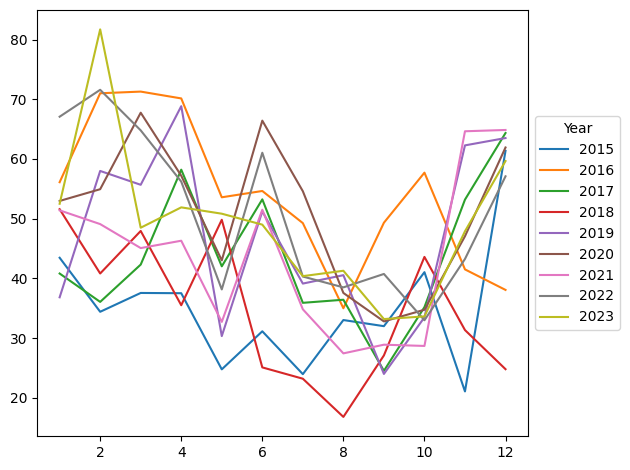

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'd' is your DataFrame
plt.figure(figsize=(14, 8))  # Increase the figure size
ax = d.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Year')  # Position the legend outside
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
d.to_csv(r'/content/drive/MyDrive/rs/vci_mogador.csv')

In [ ]:
def calculate_lst(image):
    thermal_bands = image.select('ST_B10').multiply(0.00341802).add(149).rename('lst') #	0.00341802
    return image.addBands(thermal_bands)

In [ ]:
def tci(month , year ,  start_year  ):
  #extraction du lst pour la periode
  start_date = ee.Date.fromYMD(year, month, 1)
  end_date = start_date.advance(1, 'month')
  collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(start_date, end_date).filterBounds(roi).map(calculate_lst)
  clipped_collection = collection.map(lambda image: image.clip(roi))
  lst_month = clipped_collection.select('lst').mean().rename('lst_mean')
  # trouver la valeur max / min pour le mois correspondant pendant chaque annee
  lst_month_years = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(ee.Date.fromYMD(start_year, 1, 1), ee.Date.fromYMD(year, 12, 31)).filter(ee.Filter.calendarRange(month,month,'month')).filterBounds(roi).map(calculate_lst).map(lambda image: image.clip(roi))
  lst_max =  lst_month_years.select('lst').max().rename('lst_max')
  lst_min =  lst_month_years.select('lst').min().rename('lst_min')
  tci = lst_month.expression(
        '((lst_max - lst_mean) / (lst_max - lst_min)) * 100', {
            'lst_mean': lst_month,
            'lst_min': lst_min,
            'lst_max': lst_max
        }).rename('tci')
  return tci.set('year', year)

In [ ]:
def tci_dataframe(start  , end , start_year  ):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_tci = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = tci(month , year , start_year  )
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du tci de l'image corrrepondante a l'annee et  mois
      mean_tci = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_tci is not None:
              matrice_tci[month-1, year - start] = mean_tci["tci"]
      else:
              matrice_tci[month-1, year - start] = np.nan  # Use NaN for missing values
    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_tci, index=column, columns=index)
  return df

In [ ]:
d_tci =  tci_dataframe(2015 , 2023 , 2014 )
d_tci


,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,51.262297,28.660636,53.166643,26.097833,16.078977,19.449128,37.203969,26.238176,13.946919
2,45.627254,22.746010,40.914603,37.912090,56.214815,7.759373,43.147254,21.156104,70.153647
3,40.316825,48.913519,39.064039,65.508904,26.051489,39.431676,38.124005,37.763960,9.560005
4,35.653230,42.696131,34.253583,38.804105,48.973778,21.651447,30.925005,36.858797,17.392774
5,26.392307,45.890493,25.191084,49.395746,14.300048,18.287430,23.337407,19.526182,30.429941
6,33.194010,28.105827,38.694457,53.460608,49.180317,54.112194,53.864729,57.327831,25.803289
7,23.092954,30.453923,18.948169,33.751593,26.686595,32.503035,24.070780,17.925754,15.215537
8,37.272286,10.307762,15.303646,15.593580,28.144797,13.171657,16.379863,18.558644,13.728164
9,42.813346,46.343467,13.932970,18.158904,11.519844,12.434511,11.426644,21.981853,11.613868
10,49.917092,46.590351,11.159900,39.040521,15.196894,20.758252,13.719967,11.676444,15.982143


In [ ]:
d_tci.to_csv(r'/content/drive/MyDrive/rs/tci_mogador.csv')

<Figure size 10000x10000 with 0 Axes>

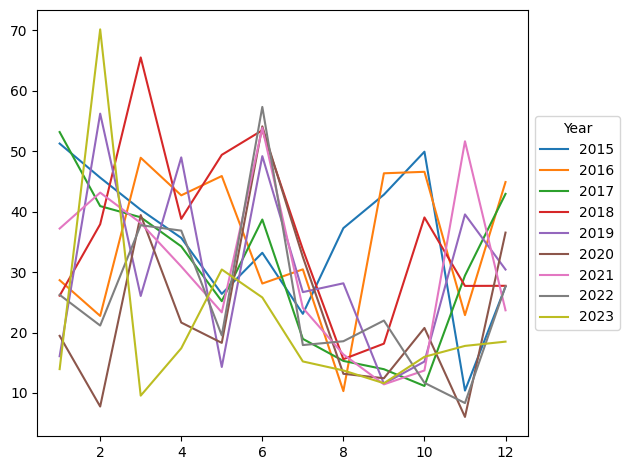

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'd' is your DataFrame
plt.figure(figsize=(100, 100))  # Increase the figure size
ax = d_tci.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Year')  # Position the legend outside
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
roii = geemap.shp_to_ee(shapefile_path).geometry
tci_image = tci(4, 2023 , 2014 , 2023)
mean_tci = tci_image.reduceRegion(reducer=ee.Reducer.min(),geometry=roi,  scale=300).getInfo()
print(mean_tci)

NameError: name 'tci' is not defined

In [ ]:

m = geemap.Map()
m.add_layer(tci(3, 2023 , 2014 , 2023))
m

Exception: Please set a secret named 'EE_PROJECT_ID' in Colab or provide a project ID.

In [ ]:
#calcul de l'indeice VHI
#l'indice vhi se base simultanement sur le calcule du vci et de tci on utilise alors les deux fonction d'une maniere qui est combinee \
def vhi(alpha  , month, year , start_date ):
  vci_tmp = vci(month, year , start_date)
  tci_tmp = tci(month, year , start_date)
  vhi_img = vci_tmp.multiply(0.5).add(tci_tmp.multiply(1 - 0.5)).rename('vhi')
  return  vhi_img.set('year', year)

In [ ]:
mean = vhi(0.5 , 3, 2020 , 2014).reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
mean

{'vhi': 53.59040750920548}

In [ ]:
def vhi_dataframe(alpha, start  , end , start_year ):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_vhi = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = vhi(alpha , month , year , start_year  )
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du vhi de l'image corrrepondante a l'annee et  mois
      mean_vhi = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_vhi is not None:
              matrice_vhi[month-1, year - start] = mean_vhi["vhi"]
      else:
              matrice_vhi[month-1, year - start] = np.nan  # Use NaN for missing values
    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_vhi, index=column, columns=index)
  return df

In [ ]:
d_vhi =  vhi_dataframe(0.5 , 2015 , 2023 , 2014 )
d_vhi

,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,47.356667,42.404990,46.986983,38.835599,26.457444,36.212761,44.299641,46.657324,33.224522
2,40.011184,46.888074,38.497334,39.366990,57.102136,31.346018,46.117658,46.372433,75.933133
3,38.935797,60.097208,40.685345,56.733791,40.861304,53.590408,41.597656,51.275051,29.020858
4,36.584739,56.416515,46.228727,37.151942,58.905998,39.420803,38.616155,46.530336,34.642268
5,25.574530,49.735135,33.602303,49.603122,22.313908,30.651071,28.022655,28.836317,40.629333
6,32.163109,41.370058,45.962721,39.272678,50.195458,60.263358,52.678427,59.182536,37.399132
7,23.523537,39.852354,27.424738,28.470724,32.905537,43.548197,29.443211,29.114193,27.792238
8,35.144123,22.648805,25.860927,16.193267,34.338956,25.362890,21.906575,28.523021,27.500159
9,37.405137,47.830795,19.219662,22.626617,17.754854,22.610392,20.156548,31.359011,22.397737
10,45.476340,52.146723,23.171710,41.319932,24.335819,27.749931,21.199201,22.327802,24.801683


<Figure size 10000x10000 with 0 Axes>

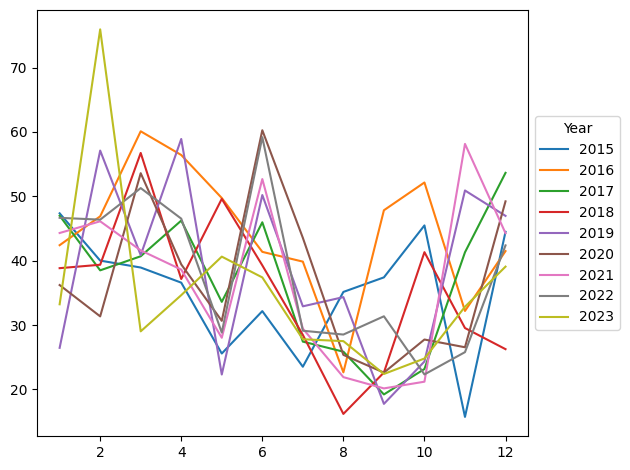

In [ ]:
# extraction du spi
import matplotlib.pyplot as plt
# Assuming 'd' is your DataFrame
plt.figure(figsize=(100, 100))  # Increase the figure size
ax = d_vhi.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Year')  # Position the legend outside
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
d_vhi.to_csv(r'/content/drive/MyDrive/rs/vhi_mogador.csv')

In [ ]:
d_vhi

,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,47.356667,42.404990,46.986983,38.835599,26.457444,36.212761,44.299641,46.657324,33.224522
2,40.011184,46.888074,38.497334,39.366990,57.102136,31.346018,46.117658,46.372433,75.933133
3,38.935797,60.097208,40.685345,56.733791,40.861304,53.590408,41.597656,51.275051,29.020858
4,36.584739,56.416515,46.228727,37.151942,58.905998,39.420803,38.616155,46.530336,34.642268
5,25.574530,49.735135,33.602303,49.603122,22.313908,30.651071,28.022655,28.836317,40.629333
6,32.163109,41.370058,45.962721,39.272678,50.195458,60.263358,52.678427,59.182536,37.399132
7,23.523537,39.852354,27.424738,28.470724,32.905537,43.548197,29.443211,29.114193,27.792238
8,35.144123,22.648805,25.860927,16.193267,34.338956,25.362890,21.906575,28.523021,27.500159
9,37.405137,47.830795,19.219662,22.626617,17.754854,22.610392,20.156548,31.359011,22.397737
10,45.476340,52.146723,23.171710,41.319932,24.335819,27.749931,21.199201,22.327802,24.801683


In [ ]:
# calcul du spi
#formule SPI=(P−Pavg)/σ on calcule le SPI pour chaque annnee sur une periode de 12 mois , d ou le nom de spi_12
#caclul du spi pour un mois duran une annee specifique
def spi_12(month , year):
  #extraction du lst pour la periode
  start_date = ee.Date.fromYMD(year, month , 1)
  end_date = start_date.advance(1, 'month')
  # calcul de la valeur moyen pour le mois correpondant de l'annee correspondante
  collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(start_date, end_date).filterBounds(roi)
  # calcul des valeur Pavg et σ pour chaque pixel
  clipped_collection = collection.map(lambda image: image.clip(roi))
  mean_precipitation_month = clipped_collection.select('precipitation').mean().rename('mean_precipitation_month')
  # trouver la valeur sigma de la deviation standard et la valeur moyenne  pour l'annne considee
  precipitation_years = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)).filterBounds(roi).map(lambda image: image.clip(roi))
  p_mean_year         =  precipitation_years.select('precipitation').reduce(ee.Reducer.mean()).rename('mean_precipitation')
  p_variance_year      =  precipitation_years.select('precipitation').reduce(ee.Reducer.variance()).rename('simga_precipitation')
  # SPI=(P−Pavg)/σ
  spi_12  = mean_precipitation_month.expression(
        '(mean_precipitation_month - mean_precipitation) / simga_precipitation', {
            'mean_precipitation_month': mean_precipitation_month,
            'mean_precipitation': p_mean_year,
            'simga_precipitation': p_variance_year
        }).rename('spi_12')
  return spi_12.set('year', year)

In [ ]:
img = spi_12(3 , 2014 )
roii = geemap.shp_to_ee(shapefile_path).geometry
img = spi_12(3 , 2014 )
mean_vci = img.reduceRegion(reducer=ee.Reducer.min(), geometry=roi, scale=300).getInfo()
print(mean_vci)

{'spi_12': -0.008179647010068947}


In [ ]:
#generation de la serie temprellle du spi_12
def spi_12_dataframe(start , end):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_spi_12 = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = spi_12(month , year)
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du spi_12 de l'image corrrepondante a l'annee et  mois
      mean_spi_12 = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_spi_12 is not None:
              matrice_spi_12[month-1, year - start] = mean_spi_12["spi_12"]
      else:
              matrice_spi_12[month-1, year - start] = np.nan  # Use NaN for missing values
    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_spi_12, index=column, columns=index)
  return df

In [ ]:
%%time
d_spi =  spi_12_dataframe(2014 , 2023)
d_spi

CPU times: user 13.2 s, sys: 1.26 s, total: 14.4 s
Wall time: 26min 45s


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.024441,0.041542,-0.012739,0.010972,0.022075,-0.009542,0.037005,0.106532,0.010949,-0.006222
2,-0.018779,-0.004450,0.023021,0.124998,0.018652,0.012311,-0.041705,0.081246,-0.015820,0.322238
3,0.023041,0.115597,0.019733,0.041627,0.032885,0.075326,0.057304,0.083985,0.156382,0.000236
4,0.015152,-0.016785,-0.019025,0.011632,0.019179,0.048485,0.051672,-0.016446,0.038401,0.039872
5,-0.020829,-0.033743,0.032590,-0.029310,-0.014308,-0.009229,0.020613,-0.022790,-0.021317,-0.029032
6,-0.041894,-0.054582,-0.051384,-0.049499,-0.049447,-0.055079,-0.058892,-0.040005,-0.045231,-0.087245
7,-0.045014,-0.053176,-0.050427,-0.062485,-0.050344,-0.065856,-0.082004,-0.069553,-0.065713,-0.093705
8,-0.043420,-0.050372,-0.048840,-0.059111,-0.047478,-0.062295,-0.083128,-0.069522,-0.065739,-0.081715
9,-0.026978,-0.014073,-0.030817,-0.034054,-0.018991,-0.052302,-0.055132,-0.044486,-0.036091,-0.066120
10,-0.025671,0.076135,0.008548,-0.018168,0.057605,-0.014353,-0.009887,-0.025603,-0.008661,0.058273


In [ ]:
d_spi.to_csv("/content/drive/MyDrive/rs/spi_mogador.csv")

In [ ]:
# calcul de l'indice pci
# formule de calcul  PCI = 100 * (TRMM - TRMM min ) / (TRMM max - TRMM min) (Lingtong Du et al.)
def pci(month , year, start_year) :
  #extraction du lst pour la periode
  start_date = ee.Date.fromYMD(year, month, 1)
  end_date = start_date.advance(1, 'month')
  collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(start_date, end_date).filterBounds(roi)
  clipped_collection = collection.map(lambda image: image.clip(roi))
  precipitation_month = clipped_collection.select('precipitation').mean().rename('precipitation_mean')
  # trouver la valeur max / min pour le mois correspondant pendant chaque annee
  precipitation_month_years = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').select('precipitation').filterDate(ee.Date.fromYMD(start_year, 1, 1), ee.Date.fromYMD(year, 12, 31)).filter(ee.Filter.calendarRange(month,month,'month')).filterBounds(roi).map(lambda image: image.clip(roi))
  precipitation_max =  precipitation_month_years.select('precipitation').max().rename('percipitation_max')
  precipitation_min =  precipitation_month_years.select('precipitation').min().rename('precipitation_min')
  pci = precipitation_month.expression(
        '(( precipitation_mean -precipitation_min)/(precipitation_max-precipitation_min))*100', {
            'precipitation_mean': precipitation_month,
            'precipitation_min': precipitation_min,
            'precipitation_max': precipitation_max
        }).rename('pci')
  return pci.set('year', year)

In [ ]:
def pci_dataframe( start  , end , start_year ):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_pci = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = pci( month , year , start_year  )
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du pci de l'image corrrepondante a l'annee et  mois
      mean_pci = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_pci is not None:
              matrice_pci[month-1, year - start] = mean_pci["pci"]
      else:
              matrice_pci[month-1, year - start] = np.nan  # Use NaN for missing values
    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_pci, index=column, columns=index)
  return df

In [ ]:
%%time
d_pci  = pci_dataframe(2015 , 2023 , 2004)
d_pci

CPU times: user 27.8 s, sys: 4.19 s, total: 32 s
Wall time: 1h 40min


,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,2.002587,1.333892,1.418011,2.809457,0.953189,1.778205,3.079158,1.530009,0.998951
2,1.698098,3.414324,4.728578,3.294642,1.814773,0.811119,3.365108,1.300636,5.955083
3,3.192734,2.181403,1.762872,2.770115,2.204948,1.783785,2.315281,3.609567,0.876550
4,1.199500,1.437013,1.826979,3.488051,2.546927,2.486966,1.146154,2.481964,1.839121
5,1.544909,5.386224,1.248375,2.415223,1.971168,2.934709,1.536020,1.628673,1.391156
6,2.090044,0.354510,2.591974,0.263364,2.038470,4.038242,5.094898,4.045768,0.859239
7,7.266765,1.546314,0.029507,0.000000,0.462243,1.068824,0.030181,0.151226,0.287348
8,5.054571,1.863708,1.194445,1.804298,1.115396,0.385874,0.032566,0.138783,2.693579
9,3.167879,2.287350,1.970087,4.143399,0.915834,1.406161,1.419328,2.057643,1.153051
10,4.248644,3.268384,1.414985,5.397834,1.300495,1.470821,1.011142,1.495643,2.357085


In [ ]:
d_pci.to_csv("/content/drive/MyDrive/rs/pci_mogador.csv")

In [ ]:
def pci_15(month , year, start_year) :
  #extraction du lst pour la periode
  start_date = ee.Date.fromYMD(year, month, 1)
  end_date = start_date.advance(1, 'month')
  collection = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(start_date, end_date).filterBounds(roi)
  clipped_collection = collection.map(lambda image: image.clip(roi))
  precipitation_month = clipped_collection.select('precipitation').mean().rename('precipitation_mean')
  # trouver la valeur max / min pour le mois correspondant pendant chaque annee
  precipitation_month_years = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').select('precipitation').filterDate(ee.Date.fromYMD(start_year, 1, 1), ee.Date.fromYMD(year, 12, 31)).filter(ee.Filter.calendarRange(month,month,'month')).filterBounds(roi).map(lambda image: image.clip(roi))
  precipitation_max =  precipitation_month_years.select('precipitation').max().rename('percipitation_max')
  precipitation_min =  precipitation_month_years.select('precipitation').min().rename('precipitation_min')
  pci = precipitation_month.expression(
        '(( precipitation_mean -precipitation_min)/(precipitation_max-precipitation_min))*100', {
            'precipitation_mean': precipitation_month,
            'precipitation_min': precipitation_min,
            'precipitation_max': precipitation_max
        }).rename('pci')
  return pci.set('year', year)
def pci_15_dataframe( start  , end , start_year ):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_pci = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = pci_15( month , year , start_year  )
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du pci de l'image corrrepondante a l'annee et  mois
      mean_pci = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_pci is not None:
              matrice_pci[month-1, year - start] = mean_pci["pci"]
      else:
              matrice_pci[month-1, year - start] = np.nan  # Use NaN for missing values
    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_pci, index=column, columns=index)
  return df


In [ ]:
p = pci_15_dataframe(2015 , 2023 , 2013)
p

,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,15.895658,7.475985,8.874081,27.115142,2.958449,13.565108,25.212240,9.142043,3.227056
2,19.833177,37.896426,34.463640,23.583686,11.162737,3.217139,24.297814,6.934336,33.352787
3,18.011204,10.433401,7.460433,17.275106,12.574279,8.124243,12.663016,25.237424,1.364345
4,4.326380,6.754164,11.260672,26.962628,18.453587,17.822195,4.055810,17.531716,10.831029
5,11.607966,35.342567,4.108305,12.859949,9.604293,17.582098,6.610157,7.344069,5.340752
6,31.184226,28.127278,35.365009,18.100872,22.191994,39.283450,32.730425,23.474146,9.897022
7,40.845296,16.340353,7.690090,7.512606,13.329212,8.891310,7.336650,8.010369,8.168123
8,30.190518,15.083667,9.935337,13.492546,10.178925,8.562728,7.092056,7.758033,15.433408
9,21.565072,14.131831,13.182654,29.396582,5.408951,6.892784,7.669881,12.692749,6.095125
10,32.750124,23.061055,6.174585,29.219798,3.869224,5.030168,2.481953,5.255642,11.297548


In [ ]:
p

NameError: name 'p' is not defined

<Figure size 7000x7000 with 0 Axes>

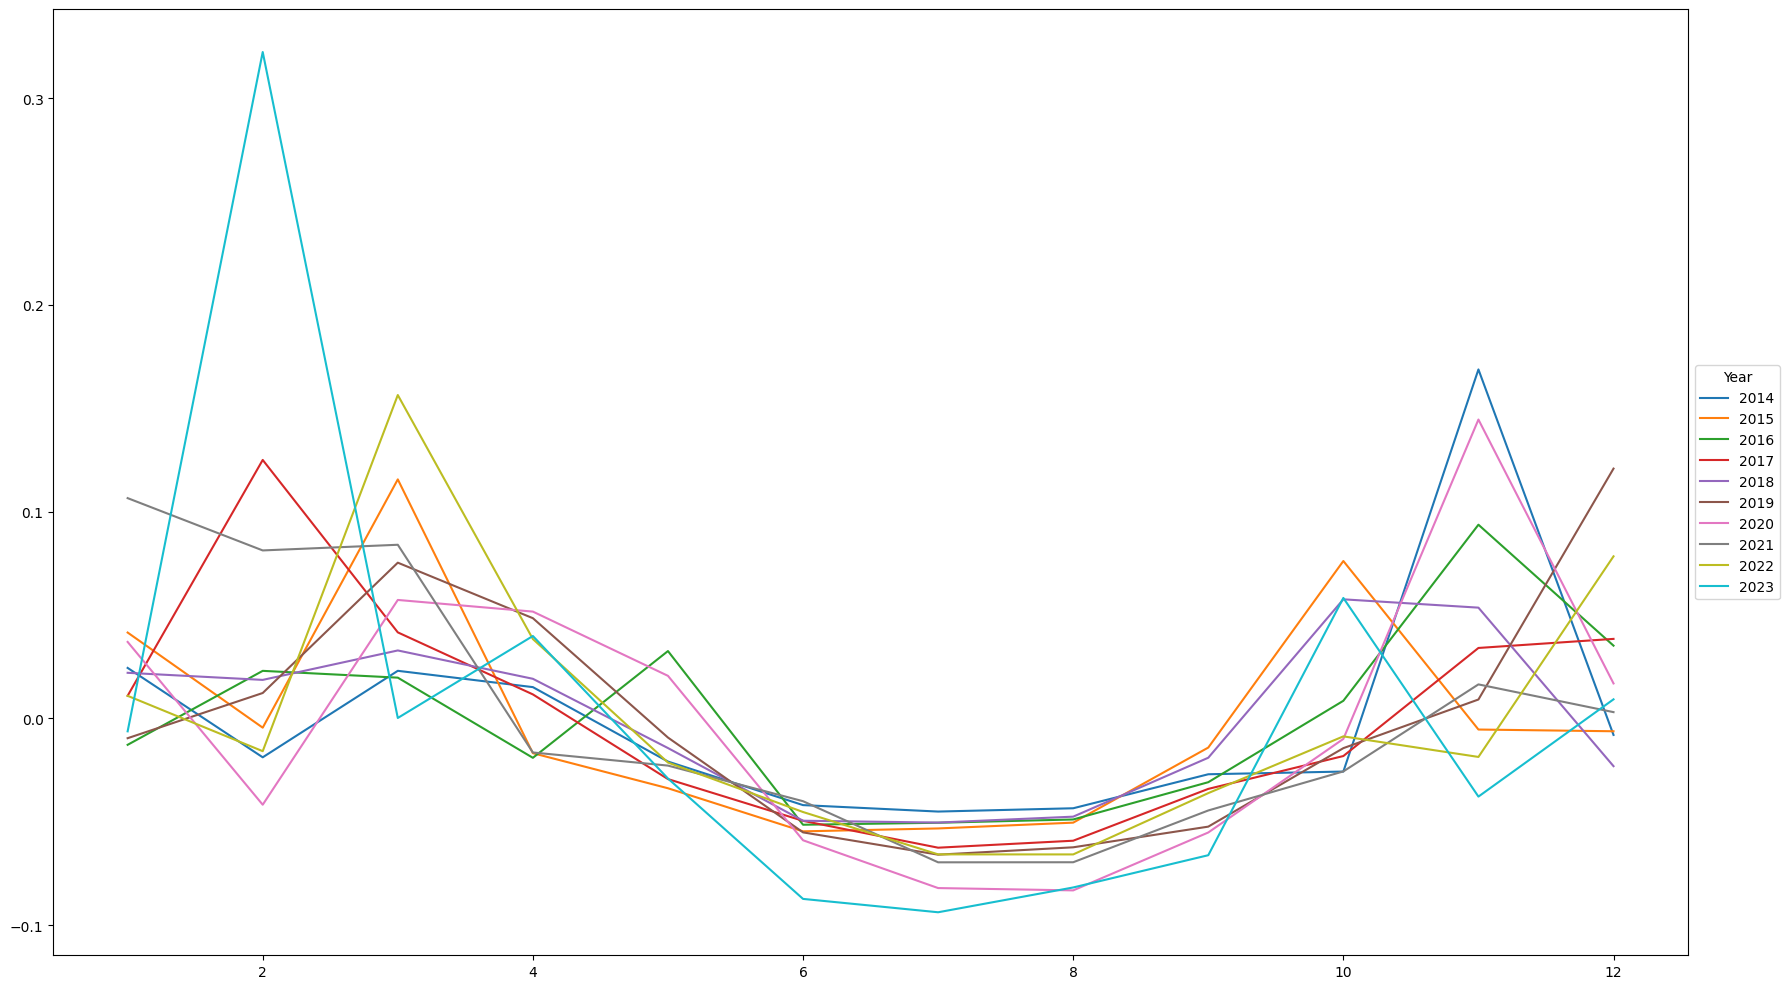

In [ ]:
# extraction du spi
import matplotlib.pyplot as pyplt

pyplt.rcParams["figure.figsize"] = (18, 10)


# Assuming 'd' is your DataFrame
plt.figure(figsize=(70, 70))  # Increase the figure size
ax = d_spi.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Year')  # Position the legend outside
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

<Axes: >

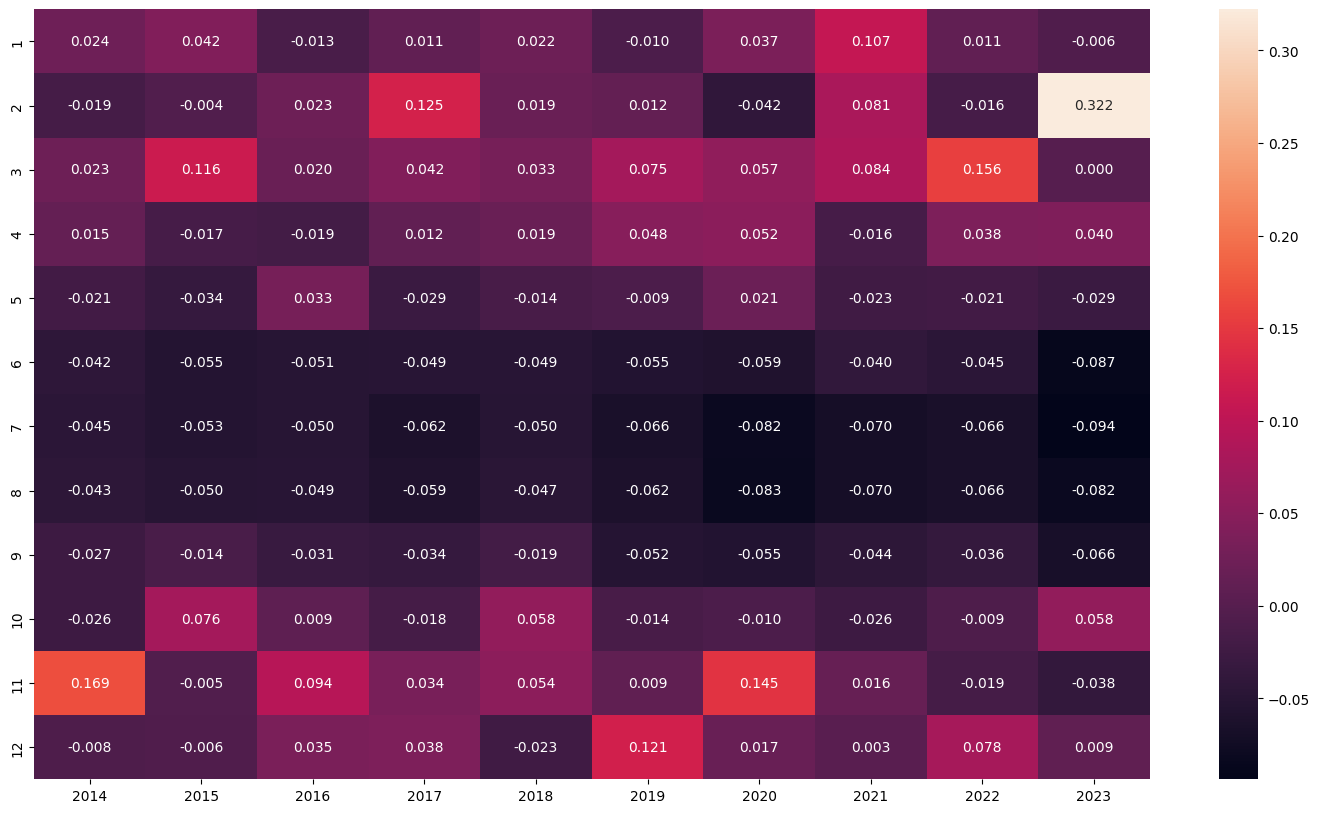

In [ ]:
#analyse de correlation  + resultat
#apres extraction des series temporel on commence par l'analyse de correlation entre les differents indices comme les donnee
import seaborn as sns
sns.heatmap(d_spi  , annot = True , fmt=".3f")

In [ ]:
# generation des cartes et
#calcul du spi_1 / recalculer spi_12


# **ANALYSE DES SERIES TEMPORELLES / VISUALISATION**

In [ ]:


# Define a function to create an SLD style color ramp
def make_color_ramp(colors, positions, minValue, maxValue):
    return '<RasterSymbolizer>' + \
           '<ColorMap type="ramp" extended="false" >' + \
           ''.join([
               '<ColorMapEntry color="{}" quantity="{}" label="{}" />'.format(color, pos, round(pos * (maxValue - minValue) + minValue))
               for color, pos in zip(colors, positions)
           ]) + \
           '</ColorMap>' + \
           '</RasterSymbolizer>'

# Assuming tci() function and roi are defined elsewhere
image = vci(3,2021 ,  2013)

# Visualization parameters
vis_params = {
    'min': 0,
    'max': 50,
    'palette': ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#00ff00']
}

# Clip tci image to ROI
image_clipped = image.clip(roi)

# Create a map centered on the ROI
Map = geemap.Map(zoom=5)

# Add tci image as a layer to the map
Map.addLayer(image_clipped, vis_params, 'tci Image')
Map.addLayer(roi)

# Define legend colors and labels
legend_colors = ['#ff0000', '#ff8000', '#ffff00', '#80ff00', '#00ff00']
legend_labels = ['0-10 Extreme Drought', '10-20 Severe Drought', '20-30 Moderate Drought', '30-40 Mild Drought', '40-50 No Drought']

# Add custom legend using HTML
legend_html = '<h4 style="margin-bottom:0"><b>tci Legend</b></h4>' + \
              '<div style="display:flex; flex-direction:column;">'
for i, color in enumerate(legend_colors):
    legend_html += '<div style="display:flex; align-items:center;">' + \
                   '<div style="background-color: {}; width: 20px; height: 20px; margin-right: 5px;"></div>'.format(color) + \
                   '<div style="padding-top: 5px;">{}</div>'.format(legend_labels[i]) + \
                   '</div>'
legend_html += '</div>'

Map.add_html(legend_html, position='bottomright')

# Display the map
Map.add_layer_control()
Map


In [ ]:
d_tci =  tci_dataframe(2014 , 2023 , 2014 , 2023)
d_tci

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,20.134592,41.408622,11.497488,40.520354,25.590363,17.032857,19.319311,37.351480,13.959993,13.955402
2,34.415119,37.715538,19.894146,26.782751,32.247176,49.002461,7.625842,43.325206,21.156104,111.045808
3,18.100843,27.153010,28.140608,35.409732,45.097201,23.037924,33.804118,41.616457,37.763960,9.076525
4,27.679516,15.713606,24.083730,13.153417,29.091124,47.933754,29.985780,29.953448,45.748031,16.771533
5,33.552996,12.478928,44.732876,22.445162,48.237417,15.109766,21.714835,23.172633,24.977802,34.613445
6,28.800627,24.185150,14.932262,18.666468,22.631997,22.115305,25.030840,38.798597,57.327831,28.713927
7,37.052850,10.490515,23.503134,14.796352,26.661272,21.422010,32.145397,18.025475,17.925754,15.022212
8,19.221290,36.958770,13.841590,17.639271,12.222915,30.262569,17.260152,15.924584,18.558644,13.897129
9,20.920462,29.827892,43.818523,13.806716,18.303314,11.341654,12.683417,11.041937,22.137179,12.067940
10,7.874894,25.586814,31.021474,6.233429,38.972743,16.228202,22.344739,13.752427,13.226706,9.509813


In [ ]:
d_tci =  tci_dataframe(2014, 2023 , 2014 , 2023)
d_tci

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,20.134592,41.408622,11.497488,40.520354,25.590363,17.032857,19.319311,37.351480,13.959993,13.955402
2,34.415119,37.715538,19.894146,26.782751,32.247176,49.002461,7.625842,43.325206,21.156104,111.045808
3,18.100843,27.153010,28.140608,35.409732,45.097201,23.037924,33.804118,41.616457,37.763960,9.076525
4,27.679516,15.713606,24.083730,13.153417,29.091124,47.933754,29.985780,29.953448,45.748031,16.771533
5,33.552996,12.478928,44.732876,22.445162,48.237417,15.109766,21.714835,23.172633,24.977802,34.613445
6,28.800627,24.185150,14.932262,18.666468,22.631997,22.115305,25.030840,38.798597,57.327831,28.713927
7,37.052850,10.490515,23.503134,14.796352,26.661272,21.422010,32.145397,18.025475,17.925754,15.022212
8,19.221290,36.958770,13.841590,17.639271,12.222915,30.262569,17.260152,15.924584,18.558644,13.897129
9,20.920462,29.827892,43.818523,13.806716,18.303314,11.341654,12.683417,11.041937,22.137179,12.067940
10,7.874894,25.586814,31.021474,6.233429,38.972743,16.228202,22.344739,13.752427,13.226706,9.509813


In [ ]:
#calcul de l'indeice VHI
#l'indice vhi se base simultanement sur le calcule du vci et de tci on utilise alors les deux fonction d'une maniere qui est combinee \
def vhi(alpha  , month, year , start_date ):
  vci = vci(month, year , start_date)
  tci = tci(month, year , start_date)
  vhi = vci.multiply(0.5).add(tci.multiply(1 - 0.5))
  return  vhi.set('year', year)



In [ ]:
def vhi_dataframe(start  , end , start_year , end_year ):
  #initialisatoin du matice des observation
  index = [i for i in range(start , end+1)]
  column =[i for i in range(1,13)]
  matrice_vhi = np.zeros((12,end - start+1))
  for month in range(1, 13):
    for year in range(start , end+1):
      image = vhi(month , year , start_year , end_year )
      #var maxValue = image.reduce(ee.Reducer.max());
      #extraction du vhi de l'image corrrepondante a l'annee et  mois
      mean_vhi = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=300).getInfo()
      if mean_vhi is not None:
              matrice_vhi[month-1, year - start_year] = mean_vhi["vhi"]
      else:
              matrice_vhi[month-1, year - start_year] = np.nan  # Use NaN for missing values
    # Create a pandas DataFrame
  df = pd.DataFrame(matrice_vhi, index=column, columns=index)
  return df

In [ ]:
#test
imagevhi = vhi(0.5 , 11, 2015  , 2013 , 2023 )
#clipped_dataset = dataset.map(lambda image: image.clip(roi))
m = geemap.Map()
m.add_layer(imagevhi )
m

In [ ]:
# Define a function to create an SLD style color ramp
def make_color_ramp(colors, positions, minValue, maxValue):
    return '<RasterSymbolizer>' + \
           '<ColorMap type="ramp" extended="false" >' + \
           ''.join([
               '<ColorMapEntry color="{}" quantity="{}" label="{}" />'.format(color, pos, round(pos * (maxValue - minValue) + minValue))
               for color, pos in zip(colors, positions)
           ]) + \
           '</ColorMap>' + \
           '</RasterSymbolizer>'
# Assuming vhi() function and roi are defined elsewhere
vhi_image = vhi(5, 2014 , 2014 , 2024)
# Visualization parameters
vis_params = {
    'min': 0,
    'max': 100,
    'palette': ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
}
# Clip vhi image to ROI
vhi_image_clipped = vhi_image.clip(roi)
# Create a map centered on the ROI
Map = geemap.Map( zoom=5)
# Add vhi image as a layer to the map
Map.addLayer(vhi_image_clipped, vis_params, 'vhi Image')
Map.addLayer(roi)
# Define legend colors and labels
legend_colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
legend_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
# Add custom legend using HTML
legend_html = '<h4 style="margin-bottom:0"><b>vhi Legend</b></h4>' + \
              '<div style="display:flex; flex-direction:row;">'
for i, color in enumerate(legend_colors):
    legend_html += '<div style="background-color: {}; width: 20px; height: 20px; margin-right: 5px;"></div>'.format(color) + \
                   '<div style="padding-top: 5px;">{}</div>'.format(legend_labels[i])
legend_html += '</div>'
Map.add_html(legend_html, position='bottomright')
# Display the map
Map.add_layer_control()
Map


<Axes: >

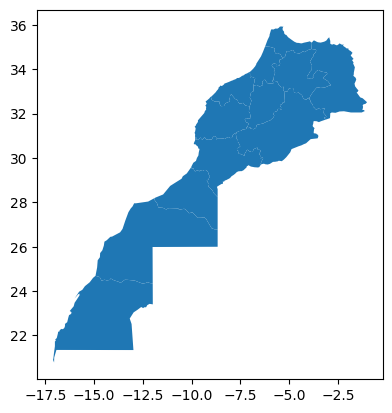

In [ ]:
import geopandas as gpd
file = gpd.read_file('/content/drive/MyDrive/maroc.shp')
file.plot()

In [ ]:
import ee
import geemap

# Define a function to create an SLD style color ramp
def make_color_ramp(colors, positions, minValue, maxValue):
    return '<RasterSymbolizer>' + \
           '<ColorMap type="ramp" extended="false" >' + \
           ''.join([
               '<ColorMapEntry color="{}" quantity="{}" label="{}" />'.format(color, pos, round(pos * (maxValue - minValue) + minValue))
               for color, pos in zip(colors, positions)
           ]) + \
           '</ColorMap>' + \
           '</RasterSymbolizer>'

# Assuming vci() function and roi are defined elsewhere
vci_image = vci(9, 2020 , 2014 , 2024)

# Visualization parameters
vis_params = {
    'min': 0,
    'max': 100,
    'palette': ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
}

# Clip VCI image to ROI
vci_image_clipped = vci_image.clip(roi)

# Create a map centered on the ROI
Map = geemap.Map( zoom=5)

# Add VCI image as a layer to the map
Map.addLayer(vci_image_clipped, vis_params, 'VCI Image')
Map.addLayer(roi)

# Define legend colors and labels
legend_colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
legend_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']

# Add custom legend using HTML
legend_html = '<h4 style="margin-bottom:0"><b>VCI Legend</b></h4>' + \
              '<div style="display:flex; flex-direction:row;">'
for i, color in enumerate(legend_colors):
    legend_html += '<div style="background-color: {}; width: 20px; height: 20px; margin-right: 5px;"></div>'.format(color) + \
                   '<div style="padding-top: 5px;">{}</div>'.format(legend_labels[i])
legend_html += '</div>'
Map.add_html(legend_html, position='bottomright')

# Display the map
Map.add_layer_control()
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
#